# Multi-Channel Pulses

Usually there is a need to define pulses for multiple control channels simulateously. While this would be possible by simply defining several separate pulse templates (one for each channel), the `qctoolkit` also allows to define pulse templates directly for multiple channels or combine existing templates in a multi-channel way. This tutorial explores these possibilities.

## A Multi-Channel Table Pulse
`TablePulseTemplate` allows to model multiple channel in a straighforward way: We simply initialize our `TablePulseTemplate` instance with the `channels` argument. When we then add new entries to it, we specify the channel for the entry with the `channel` argument of the `add_entry` method. Note that this is zero-indexed. We may share parameters between the channels. The following example constructs a 2-channel table pulse template with shared parameters and plots it.

<IPython.core.display.Javascript object>


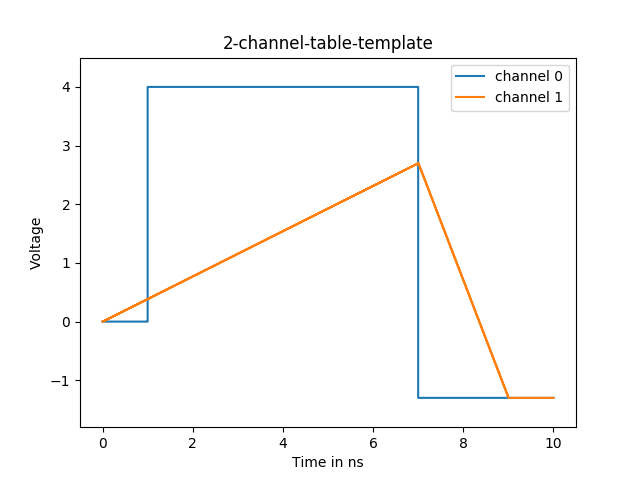

The number of channels in table_template is 2.


In [1]:
from qctoolkit.pulses import TablePulseTemplate

table_template = TablePulseTemplate(identifier='2-channel-table-template',
                                    entries={0: [(0, 0),
                                                 (1, 4),
                                                 ('foo', 'bar'),
                                                 (10, 0)],
                                             1: [(0, 0),
                                                 ('foo', 2.7, 'linear'),
                                                 (9, 'bar', 'linear')]})

# plot it
%matplotlib notebook
from qctoolkit.pulses import plot
parameters = dict(
    foo=7,
    bar=-1.3
)
_ = plot(table_template, parameters, sample_rate=100)
print("The number of channels in table_template is {}.".format(table_template.num_channels))

# Combining Templates: `MultiChannelPulseTemplate`

`MultiChannelPulseTemplate` allows to compose a multi-channel template out of atomic (i.e., no control flow) templates of equal duration. It allows to reassign channel indices of the channels of its subtemplates. The constructor is similar to the one of `SequencePulseTemplate` and expects a list of subtemplates including parameter and channel mappings as well as a set of external parameters.

The following example will combine the two-channel table pulse template `table_template` from above and a function pulse template `function_template` to a three-channel template `template`. We reassign indices such that channel 0 of `template` is channel 1 of `table_template`, channel 1 of `template` is channel 0 (the only one) of `function_template` and channel 2 of `template` is channel 0 of `table_template`.

<IPython.core.display.Javascript object>


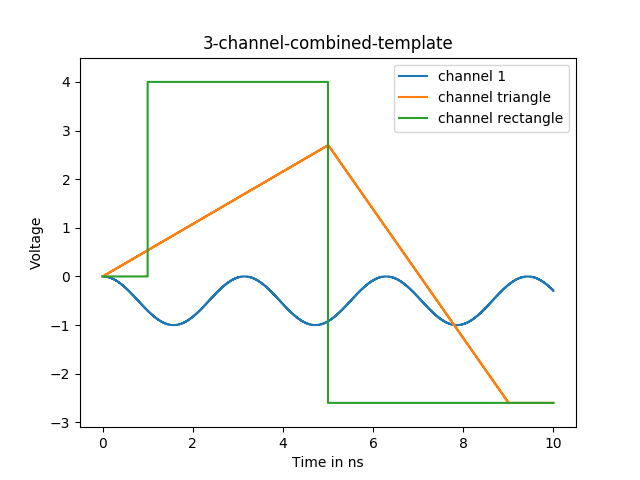

The number of channels in function_template is 1.
The number of channels in template is 3.


In [2]:
from qctoolkit.pulses import FunctionPulseTemplate, MultiChannelPulseTemplate

function_template = FunctionPulseTemplate('-sin(t)**2', '10', identifier='function-template', channel='chan_A')

template = MultiChannelPulseTemplate(
    [(function_template, dict(), {'chan_A': 1}),
     (table_template, dict(foo='5', bar='2 * hugo'), {0: 'rectangle', 1: 'triangle'})],
    {'hugo'},
    identifier='3-channel-combined-template'
)

_ = plot(template, dict(hugo=-1.3), sample_rate=100)
print("The number of channels in function_template is {}.".format(function_template.num_channels))
print("The number of channels in template is {}.".format(template.num_channels))

The syntax for the subtemplates passed into the constructor of `MultiChannelPulseTemplate` is `(template, dictionary of parameters mappings, channel mapping array)`. A value $j$ at the $i$-th index of the channel mapping array indicates that this channel of the subtemplate shall be mapped to the $j$-th channel of the newly created `MultiChannelPulseTemplate`. Note that an exception will be raised during the sampling of the waveforms (i.e., during the sequencing process) if the subtemplates have different length.

## Multiple Channels in Non-Atomic Templates

All higher order template, i.e., `SequencePulseTemplate`, `LoopPulseTemplate` and `BranchPulseTemplate` also support multiple channels insofar as that they can be composed using multi-channel atomic templates as subtemplates. They require that all these subtemplates define an equal amount of channels and raise an exception if that is not the case. The following example constructs a `SequencePulseTempate` `sequence_template` by chaining the above defined two-channel `table_template`. In the second instance of `table_template` in the sequence, we swap the channels by wrapping a `MultiChannelPulseTemplate` around it.

<IPython.core.display.Javascript object>


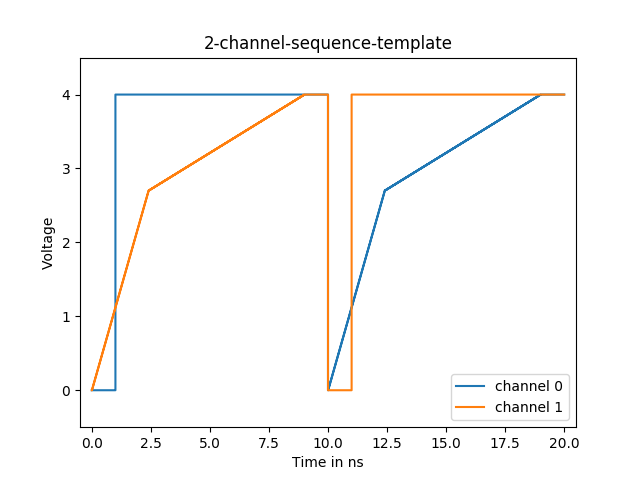

The number of channels in sequence_template is 2.


In [3]:
from qctoolkit.pulses import SequencePulseTemplate
from qctoolkit.pulses import MappingTemplate

channel_swapped_table_template = MappingTemplate(template=table_template,
                                                 channel_mapping={0: 1, 1: 0})

sequence_template = SequencePulseTemplate(
    [(table_template, dict(foo='1.2 * hugo', bar='hugo ** 2')),
     (channel_swapped_table_template, dict(foo='1.2 * hugo', bar='hugo ** 2'))],
    {'hugo'},
    identifier='2-channel-sequence-template'
)

plot(sequence_template, dict(hugo=2), sample_rate=100)
print("The number of channels in sequence_template is {}.".format(sequence_template.num_channels))